# Semi-Supervised Ensemble Model for Water Quality Prediction in Mexico

**Authors:** Raquel Cossío-Ramírez, Hortencia A. Ramírez-Vázquez, Amanda M. Valdez-Calderón

Mexico faces significant challenges in water contamination due to various factors, including natural contaminants, industrial pollution, agricultural runoff, urbanization, and overexploitation. As a result, 57% of the population lacks access to safe water.

This study’s objective is to create a semi-supervised ensemble model capable of predicting water quality by municipality based on environmental factors, such as population, inundability and industrial activity.

### Setup

Library imports, below are the necessary libraries for data processing, machine learning models, and evaluation metrics.

In [50]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.patches as mpatches
import geopandas as gpd # For .shp and .geoJSON files



In order to predict water quality for municipalities that were not covered by measuring stations, we opt to build a dataset with features that could be indirectly related to water quality. We included features per municipality such as [population](https://www.inegi.org.mx/app/biblioteca/ficha.html?upc=889463807469), [altitude](https://www.inegi.org.mx/app/biblioteca/ficha.html?upc=889463807469), [area](http://geoportal.conabio.gob.mx/metadatos/doc/html/mun22gw.html), [flood-ability threshold](https://historico.datos.gob.mx/busca/dataset/peligro-por-inundaciones-a-nivel-municipal), [number of water treatment facilities and wastewater discharge points](http://www.inegi.org.mx/app/mapas/?t=81), and [number of people working in industries](https://www.inegi.org.mx/app/descarga/ficha.html?tit=2781025&ag=0&f=csv). In this notebook [AllData.csv](https://github.com/raqcoss/ML-water/blob/main/AllData.csv) is the integration of the datasets metioned above.

In [51]:
# Load dataset 
df = pd.read_csv("AllData.csv")
df.set_index("CVEGEO", inplace=True)
df = df.drop(labels=["NOM_ENT","NOM_MUN"], axis = 1)

# Display data
df_copy = df.copy()
df

,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,agua_AR,agua_FC,agua_PT,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,semaforo
CVEGEO,,,,,,,,,,,,,
1001,948990,1918.046196,116635.92480,57.80700,4.829056,91,226,24,0.900702,21,24.193751,44.979780,Rojo
1002,51536,2030.520325,54337.42660,60.05970,4.274541,0,54,9,0.904023,0,4.500000,2.083333,Verde
1003,58250,1827.143813,92335.78323,60.71769,1.158972,7,43,4,0.787156,3,2.333333,2.835498,Rojo
1004,17000,1967.656566,12838.35445,52.22142,3.153082,10,13,3,0.912407,0,0.000000,1.000000,Rojo
1005,129929,1936.513072,49989.50916,58.46688,3.357602,34,42,16,0.798126,3,23.113636,80.622222,Rojo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32054,19446,2167.903226,37142.59866,58.41954,5.038430,11,31,3,0.794049,0,0.000000,2.000000,Rojo
32055,31558,1962.535211,215650.56020,61.17057,3.174213,4,10,2,0.726474,46,0.000000,3.076923,Rojo
32056,149607,2263.314961,43682.10105,60.79104,3.129201,5,22,2,0.785869,0,13.555556,9.888060,Rojo


The dataset consists of 2,469 rows and 13 columns, representing various geographical and environmental factors related to water quality assessment.
- **CVEGEO**: Unique geographical identifier for each municipality. 
- **POB_TOTAL**: Total population for each municipality.
- **ALTITUD**: Altitude of each municipality (in meters).
- **AREA**: Total area of each municipality (in square units).
- **UMBRAL12H**: Flooting threshold.
- **PORCENTA_1**: Percentage of flood-prone area.
- **agua_AR**: Water discharge point.
- **agua_FC**: Water intake structure.
- **agua_PT**: Drinking water service provider.
- **avg_impact**: Average human impact index.
- **avg_agricultura**, **avg_construccion**, **avg_manufactura**: Average levels of agricultural, construction, and manufacturing activities in the region.
- **semaforo**: Water quality indicator (Rojo = High risk, Amarillo = Moderate risk, Verde = Low risk, NaN = Missing data).

### Data Preprocessing and Normalization

In [52]:
# Scaling data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=["semaforo"]))
                          
X_scaled_df = pd.DataFrame(X_scaled, index=df.index, columns=df.drop(columns=["semaforo"]).columns)
X_scaled_df['semaforo'] = df['semaforo']

## Labeled/Unlabeled Data Separation
X_labeled = X_scaled_df[X_scaled_df["semaforo"].notna()].copy()  
y = X_labeled["semaforo"]  # Target labels
X_labeled = X_labeled.drop(labels="semaforo", axis=1) 

# Unlabeled samples
X_unlabeled = X_scaled_df[X_scaled_df["semaforo"].isna()].copy() 
X_unlabeled = X_unlabeled.drop(labels="semaforo", axis=1)

# Encoding 'semaforo' column into numerical labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

y_encoded = pd.DataFrame(y_encoded, index=X_labeled.index, columns=['semaforo_encoded'])
y_encoded = y_encoded.astype(int)

# Dataset with encondig values
y_df = pd.DataFrame(y_encoded, index=y.index, columns=['semaforo_encoded'])
y_df["semaforo_encoded"] = y_df["semaforo_encoded"].replace(3, -1)

### Train-Test Split

Split the labeled dataset into training and testing sets
- 20% of the data is reserved for testing 
- 80% of the data is used for training

In [53]:
x_train, x_test, y_train, y_test = train_test_split(X_labeled, y_df, test_size=0.2, random_state=42, stratify=y_df)

print(f"Train set: x_train = {x_train.shape} y_train = {y_train.shape}")

# Display mapping of categorical labels 
print("\nMapping of categorical labels to numeric values")
for index, label in enumerate(le.classes_):
    print(f"{label} → {index}")

Train set: x_train = (836, 12) y_train = (836, 1)

Mapping of categorical labels to numeric values
Amarillo → 0
Rojo → 1
Verde → 2


### Semi-Supervised Learning (SSL)

In this study, a SSL approach was employed to make use of both labeled and unlabeled data. 

It followed a self-training paradigm, in which an initial classifier trained on labeled data was iteratively refined using high-confidence predictions on unlabeled examples as pseudo-labels. Self-training was used along with an ensemble of three classification algorithms: **XGBoost**, **CatBoost** and **Random Forest**. Proposed SSL model architecture is presented in Figure 1.

<div style="text-align: center;">
    <img src="images/architecture.png" width="650" style="background-color: white; padding: 10px;">
    <p style="font-size:14px; color:gray;">Figure 1: Proposed SSL Model Architecture</p>
</div>

Selection strategy (Figure 2) for this model is very simple, where prediction probabilities are averaged for each class. If the maximum average surpasses the 0.9 threshold, the label of the said class is assigned to the municipality. 

<div style="text-align: center;">
    <img src="images/selection_strategy.png" width="500" style="background-color: white; padding: 10px;">
    <p style="font-size:14px; color:gray;">Figure 2: Selection Strategy</p>
</div>


In [54]:
# Supervised Learning Models
models = [CatBoostClassifier(iterations=500, class_weights={1: 0.31, 0: 0.42, 2: .27}, verbose=0),
        XGBClassifier(max_depth=5, reg_alpha=1),
        RandomForestClassifier(max_samples=0.5, class_weight={1: 0.31, 0: 0.42, 2: .27})
]

### Training SSL Ensamble Model

In [55]:
# Confidence threshold
threshold = 0.75

# maximum training iterations
max_iter = 50

# df_nuevo = pd.DataFrame(columns=df_copy.columns)
# df_nuevo = df_nuevo.drop(columns=["semaforo"]) 
# df_nuevo["preds"] = None

# print(df_nuevo)


for iteration in range(max_iter):

    print(f"\nIteration {iteration + 1}")
    
    print(x_train.shape, y_train['semaforo_encoded'].unique())

    # Train each model
    for model in models:
        y_train = np.squeeze(y_train)  
        model.fit(x_train, y_train)
    
    # Get predicted probabilities
    probas = [model.predict_proba(X_unlabeled) for model in models]
  

    for i, model in enumerate(models):
        model_preds = model.predict(X_unlabeled)
        unique, counts = np.unique(model_preds, return_counts=True)
        print(f"Model {i} predicted class distribution: {dict(zip(unique, counts))}")

    # Average probabilities    
    avg_probas = np.max(probas, axis=0)

    # Get confidence and predicted class
    max_probs = np.max(avg_probas, axis=1)
    preds = np.argmax(avg_probas, axis=1)
    
    # Get boolean mask of confident predictions
    confident_mask = pd.Series(max_probs >= threshold, index=X_unlabeled.index)

    if confident_mask.sum() == 0:
        print("No more confident pseudo-labels found.")
        break

    # Select high-confidence 
    new_X = X_unlabeled.loc[confident_mask]
    new_y = preds[confident_mask]

    # df_combined = pd.DataFrame(new_X) 
    # df_combined["preds"] = new_y

    # df_nuevo = pd.concat([df_nuevo, df_combined], ignore_index=False)


    #Display distribution of newly added pseudo-labels
    unique, counts = np.unique(new_y, return_counts=True)
    dist = dict(zip(unique, counts))
    print(f"Class distribution of added pseudo-labels: {dist}")

    column_name = 'semaforo_encoded'

    # Ensure both are DataFrames with the same column name
    if isinstance(y_train, pd.Series):
        y_train = y_train.to_frame(name=column_name)


    new_y_df = pd.DataFrame(new_y, index=new_X.index, columns=[column_name])
    y_train = pd.concat([y_train, new_y_df], axis=0)

    # Update labeled on dataset
    x_train = pd.concat([x_train, new_X], axis=0)

    # Remove pseudo-labeled data from unlabeled set
    X_unlabeled = X_unlabeled.drop(index=new_X.index)
    
    print(f"Added {confident_mask.sum()} new pseudo-labeled points.")



Iteration 1
(836, 12) [1 0 2]
Model 0 predicted class distribution: {0: 624, 1: 410, 2: 389}
Model 1 predicted class distribution: {0: 505, 1: 450, 2: 468}
Model 2 predicted class distribution: {0: 551, 1: 530, 2: 342}
Class distribution of added pseudo-labels: {0: 177, 1: 299, 2: 178}
Added 654 new pseudo-labeled points.

Iteration 2
(1490, 12) [1 0 2]
Model 0 predicted class distribution: {0: 206, 1: 327, 2: 236}
Model 1 predicted class distribution: {0: 201, 1: 314, 2: 254}
Model 2 predicted class distribution: {0: 156, 1: 372, 2: 241}
Class distribution of added pseudo-labels: {0: 86, 1: 117, 2: 127}
Added 330 new pseudo-labeled points.

Iteration 3
(1820, 12) [1 0 2]
Model 0 predicted class distribution: {0: 156, 1: 144, 2: 139}
Model 1 predicted class distribution: {0: 142, 1: 140, 2: 157}
Model 2 predicted class distribution: {0: 140, 1: 164, 2: 135}
Class distribution of added pseudo-labels: {0: 21, 1: 39, 2: 49}
Added 109 new pseudo-labeled points.

Iteration 4
(1929, 12) [1 

### Testing SSL Ensamble Model

In [56]:
# Probabilities for each model
test_probas = [model.predict_proba(x_test) for model in models]

# Average probabilities across models
avg_test_probas = np.max(test_probas, axis=0)

# Highest probability for each sample (Confidence level)
max_probs = np.max(avg_test_probas, axis=1)
ensemble_preds = np.argmax(avg_test_probas, axis=1)

# Ensable model's performance
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds))
print("\n",classification_report(y_test, ensemble_preds))

Ensemble Accuracy: 0.40476190476190477

               precision    recall  f1-score   support

           0       0.51      0.44      0.47        89
           1       0.35      0.55      0.43        65
           2       0.33      0.18      0.23        56

    accuracy                           0.40       210
   macro avg       0.40      0.39      0.38       210
weighted avg       0.41      0.40      0.39       210



#### Confusion Matrix

Confusion Matrix:
 [[39 39 11]
 [20 36  9]
 [18 28 10]]


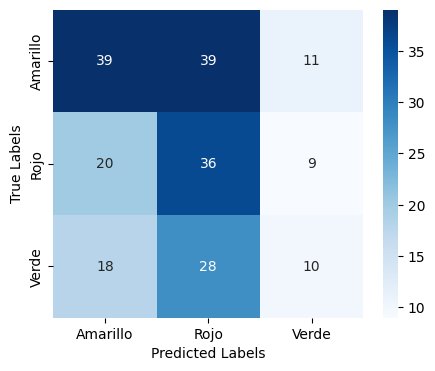

In [57]:
conf_matrix = confusion_matrix(y_test, ensemble_preds)

print("Confusion Matrix:\n", conf_matrix)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
#plt.title("Confusion Matrix - Semi-supervised Ensemble Model")
plt.show()

### Predictions
This secton shows the predictions made by the proposed SSL Ensamble Model

In [58]:
y_train = y_train.to_frame(name="semaforo_encoded") 

# Concatenate all predictions
df_new = pd.concat([y_test, y_train], axis=0)
df_new = df_new.rename(columns={"semaforo_encoded": "preds"})

df_new


,preds
CVEGEO,
7089,2
13061,1
23005,2
12011,0
26052,2
...,...
21185,0
7084,0
20159,2


In [59]:
# Merging predictions with original dataset
df_copy = df_copy.merge(df_new[['preds']], left_index=True, right_index=True, how="left")
df_copy

,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,agua_AR,agua_FC,agua_PT,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,semaforo,preds
CVEGEO,,,,,,,,,,,,,,
1001,948990,1918.046196,116635.92480,57.80700,4.829056,91,226,24,0.900702,21,24.193751,44.979780,Rojo,1.0
1002,51536,2030.520325,54337.42660,60.05970,4.274541,0,54,9,0.904023,0,4.500000,2.083333,Verde,2.0
1003,58250,1827.143813,92335.78323,60.71769,1.158972,7,43,4,0.787156,3,2.333333,2.835498,Rojo,1.0
1004,17000,1967.656566,12838.35445,52.22142,3.153082,10,13,3,0.912407,0,0.000000,1.000000,Rojo,1.0
1005,129929,1936.513072,49989.50916,58.46688,3.357602,34,42,16,0.798126,3,23.113636,80.622222,Rojo,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32054,19446,2167.903226,37142.59866,58.41954,5.038430,11,31,3,0.794049,0,0.000000,2.000000,Rojo,1.0
32055,31558,1962.535211,215650.56020,61.17057,3.174213,4,10,2,0.726474,46,0.000000,3.076923,Rojo,1.0
32056,149607,2263.314961,43682.10105,60.79104,3.129201,5,22,2,0.785869,0,13.555556,9.888060,Rojo,1.0


In [60]:
# Predictions
df_predictions = df_copy[df_copy["semaforo"].isna()]
df_predictions = df_predictions[df_predictions['preds'].notna()]
df_predictions

,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,agua_AR,agua_FC,agua_PT,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,semaforo,preds
CVEGEO,,,,,,,,,,,,,,
1006,47646,1912.241007,1.957359e+04,58.23558,6.728276,2,19,2,0.836746,0,6.0,12.722222,NaN,2.0
1009,22485,1948.772727,2.296610e+04,55.62216,2.539697,9,18,1,0.871654,0,0.0,1.750000,NaN,1.0
2006,117568,145.451977,3.409724e+06,48.67578,1.004158,0,27,0,0.358984,47,3.5,2.029412,NaN,2.0
4010,31714,213.374074,1.394607e+06,105.91920,6.762152,0,19,0,0.543774,0,0.0,1.076923,NaN,1.0
4012,15297,9.479167,2.878819e+04,118.62900,22.668040,0,0,0,0.825679,44,0.0,3.642857,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32028,2451,1497.860215,4.820085e+04,67.96404,1.511670,3,8,0,0.703315,0,0.0,1.000000,NaN,1.0
32031,8683,2082.835979,1.582976e+05,59.60943,1.461982,0,8,2,0.697977,0,6.0,1.100000,NaN,2.0
32043,1365,2196.666667,1.974781e+04,57.66498,0.558261,2,4,1,0.626921,6,0.0,1.000000,NaN,2.0


### Comparison with Random Forest

A most commonly used approach is Random Forest, that combined the output of multiple decision trees to reach a prediction. It utilizes the bagging method and feature randomness, only selecting a subset of all possible features, to create an uncorrelated forest of decision trees.

/home/raqcoss/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.5666666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.72      0.67        93
           1       0.54      0.64      0.59        67
           2       0.41      0.18      0.25        50

    accuracy                           0.57       210
   macro avg       0.52      0.51      0.50       210
weighted avg       0.54      0.57      0.54       210



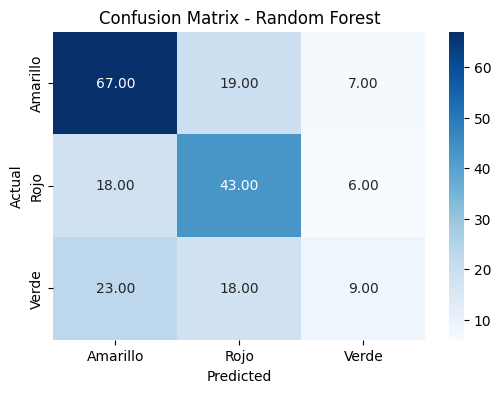

In [61]:

# Define features and target
X = X_labeled 
y = y

# Enconding 'semaforo' label
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded = pd.DataFrame(y_encoded, index=X_labeled.index, columns=['semaforo_encoded'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Training 
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Testing
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

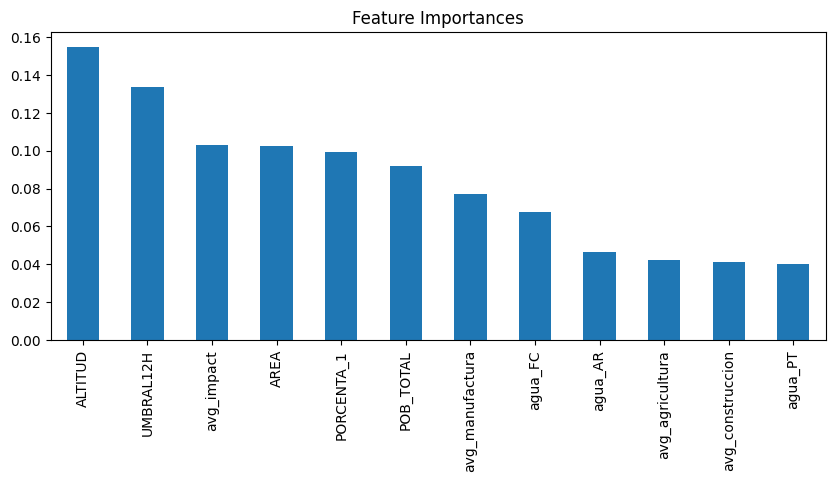

In [62]:
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind="bar", figsize=(10, 4), title="Feature Importances")
plt.show()

### Visualisation on Mexican map

In [63]:
#Defining function for plotting

def viz_on_map(df, alpha_col = None,alpha = None, color_col = 'semaforo', color_map = {
    'Rojo': 'red',
    'Amarillo': 'gold',
    'Verde': 'green'},
    title ='Water Quality Indicator by Municipality'):
    ''' This function makes a previev of the column 'semaforo' on the map of Mexico '''

    municipios_path = 'mun22gw/mun22gw.shp'
    municipios = gpd.read_file(municipios_path)
    municipios['CVEGEO'] = municipios['CVEGEO'].astype(int)
    mun_geo = municipios[['CVEGEO','geometry']].set_index('CVEGEO')
    if alpha_col:
        columns_to_plot = [alpha_col,color_col]
    else:
        columns_to_plot = color_col
    df = mun_geo.merge(df[columns_to_plot], how = 'outer', left_on='CVEGEO', right_index=True)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 7))

    # 1. First plot all geometries with full opacity (for borders)
    df.boundary.plot(ax=ax, color='black', linewidth=0.2)

    # 2. Create a new column for plotting colors
    df['plot_color'] = df[color_col].map(color_map).fillna('gray')

    # 3. Plot with confidence-based alpha
    for class_name in color_map.keys():
        # Filter features for this class
        class_data = df[df[color_col] == class_name]
        if not class_data.empty:
            # Plot with variable alpha
            if alpha_col is not None:
                class_data.plot(
                    ax=ax,
                    color=class_data['plot_color'],
                    alpha=class_data[alpha_col].fillna(0),  # Use confidence for alpha
                    edgecolor='none',
                    label=class_name)
            elif alpha is not None:
                class_data.plot(
                    ax=ax,
                    color=class_data['plot_color'],
                    alpha = alpha,
                    edgecolor='none',
                    label=class_name)
            else:
                class_data.plot(
                    ax=ax,
                    color=class_data['plot_color'],
                    edgecolor='none',
                    label=class_name)

    # 4. Create custom legend
    legend_elements = []
    for class_name, color in color_map.items():
        legend_elements.append(mpatches.Patch(
            color=color,
            label=class_name,
            alpha=1.0
        ))
    
    if alpha_col is not None:
        # Add confidence explanation
        confidence_elements = [
            mpatches.Patch(color='gray', alpha=0.3, label='Low Confidence (~50%)'),
            mpatches.Patch(color='gray', alpha=0.6, label='Medium Confidence (~70%)'),
            mpatches.Patch(color='gray', alpha=1, label='High Confidence (~100%)')
            ]
        ax.legend(
            handles=legend_elements + confidence_elements,
            title='Semaforo Classes & Confidence',
            loc='upper right'
    )
    else:
        ax.legend(
            handles=legend_elements,
            title='Semaforo Classes & Confidence',
            loc='upper right'
        )
        title = title

    plt.title(title)
    plt.tight_layout()
    plt.show()

In [64]:
def viz_on_map_with_predictions(df, df_predicted, 
                              color_col='semaforo', 
                              pred_col='preds_label',
                              color_map={
                                  'Rojo': 'red',
                                  'Amarillo': 'gold',
                                  'Verde': 'green'},
                              title='Water Quality Indicator by Municipality'):
    '''
    This function visualizes both known and predicted water quality indicators on the map of Mexico.
    Known values (semaforo) are shown with alpha=1, predicted values with alpha=0.5.
    
    Parameters:
    - df: DataFrame with known values in 'semaforo' column
    - df_predicted: DataFrame with predicted values in 'preds_label' column
    - color_col: Column name for known values (default 'semaforo')
    - pred_col: Column name for predicted values (default 'preds_label')
    - color_map: Color mapping dictionary
    - title: Plot title
    '''
    # Load municipality shapes
    municipios_path = 'mun22gw/mun22gw.shp'
    municipios = gpd.read_file(municipios_path)
    municipios['CVEGEO'] = municipios['CVEGEO'].astype(int)
    mun_geo = municipios[['CVEGEO','geometry']].set_index('CVEGEO')
    
    # Merge with known values
    df_plot = mun_geo.merge(df[[color_col]], how='left', left_on='CVEGEO', right_index=True)
    
    # Merge with predicted values if available
    if pred_col in df_predicted.columns:
        df_plot = df_plot.merge(df_predicted[[pred_col]], how='left', left_on='CVEGEO', right_index=True)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # 1. First plot all geometries with full opacity (for borders)
    df_plot.boundary.plot(ax=ax, color='black', linewidth=0.2)
    
    # 2. Create color columns
    df_plot['known_color'] = df_plot[color_col].map(color_map).fillna('gray')
    if pred_col in df_plot.columns:
        df_plot['pred_color'] = df_plot[pred_col].map(color_map).fillna('gray')
    
    # 3. Plot known values with alpha=1
    for class_name in color_map.keys():
        class_data = df_plot[df_plot[color_col] == class_name]
        if not class_data.empty:
            class_data.plot(
                ax=ax,
                color=class_data['known_color'],
                alpha=1,
                edgecolor='none',
                label=f'Known {class_name}'
            )
    
    # 4. Plot predicted values with alpha=0.5 (if available)
    if pred_col in df_plot.columns:
        for class_name in color_map.keys():
            class_data = df_plot[df_plot[pred_col] == class_name]
            if not class_data.empty:
                class_data.plot(
                    ax=ax,
                    color=class_data['pred_color'],
                    alpha=0.4,
                    edgecolor='none',
                    label=f'Predicted {class_name}'
                )
    
    # 5. Create custom legend
    legend_elements = []
    for class_name, color in color_map.items():
        legend_elements.append(mpatches.Patch(
            color=color,
            label=f'Known {class_name}',
            alpha=1.0
        ))
        legend_elements.append(mpatches.Patch(
            color=color,
            label=f'Predicted {class_name}',
            alpha=0.5
        ))
    
    ax.legend(
        handles=legend_elements,
        title='Water Quality Indicators',
        loc='upper right'
    )
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [65]:
df_copy['preds_label'] = df_copy['preds'].replace({0:'Amarillo',1:'Rojo',2:'Verde'})
df_copy

,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,agua_AR,agua_FC,agua_PT,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,semaforo,preds,preds_label
CVEGEO,,,,,,,,,,,,,,,
1001,948990,1918.046196,116635.92480,57.80700,4.829056,91,226,24,0.900702,21,24.193751,44.979780,Rojo,1.0,Rojo
1002,51536,2030.520325,54337.42660,60.05970,4.274541,0,54,9,0.904023,0,4.500000,2.083333,Verde,2.0,Verde
1003,58250,1827.143813,92335.78323,60.71769,1.158972,7,43,4,0.787156,3,2.333333,2.835498,Rojo,1.0,Rojo
1004,17000,1967.656566,12838.35445,52.22142,3.153082,10,13,3,0.912407,0,0.000000,1.000000,Rojo,1.0,Rojo
1005,129929,1936.513072,49989.50916,58.46688,3.357602,34,42,16,0.798126,3,23.113636,80.622222,Rojo,1.0,Rojo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32054,19446,2167.903226,37142.59866,58.41954,5.038430,11,31,3,0.794049,0,0.000000,2.000000,Rojo,1.0,Rojo
32055,31558,1962.535211,215650.56020,61.17057,3.174213,4,10,2,0.726474,46,0.000000,3.076923,Rojo,1.0,Rojo
32056,149607,2263.314961,43682.10105,60.79104,3.129201,5,22,2,0.785869,0,13.555556,9.888060,Rojo,1.0,Rojo


In [66]:
df_predictions['preds_label'] = df_predictions['preds'].replace({0:'Amarillo',1:'Rojo',2:'Verde'})


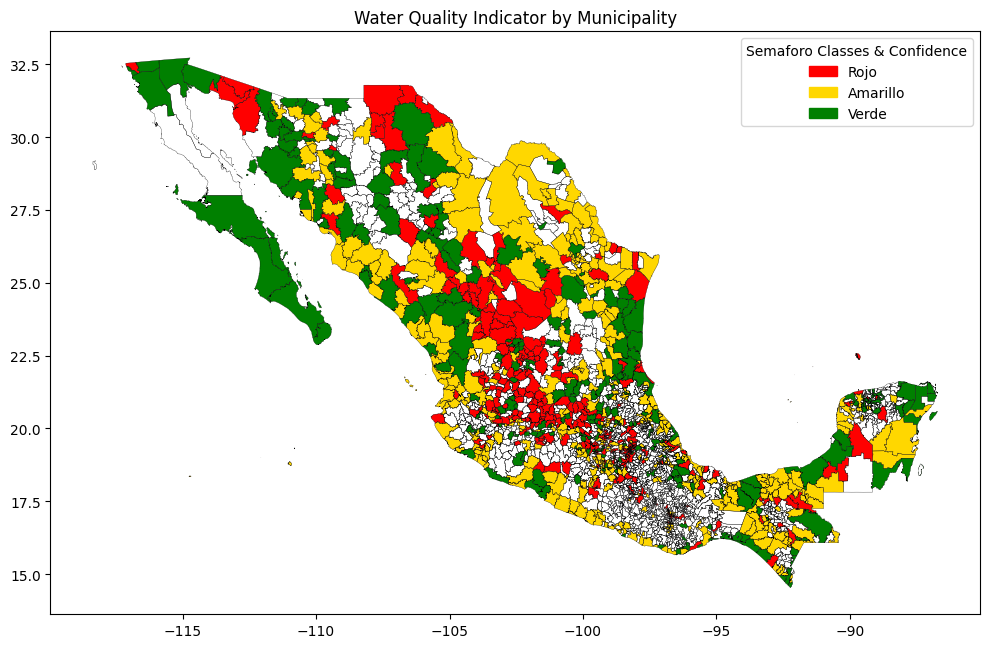

In [67]:
viz_on_map(df_copy, color_col='semaforo')

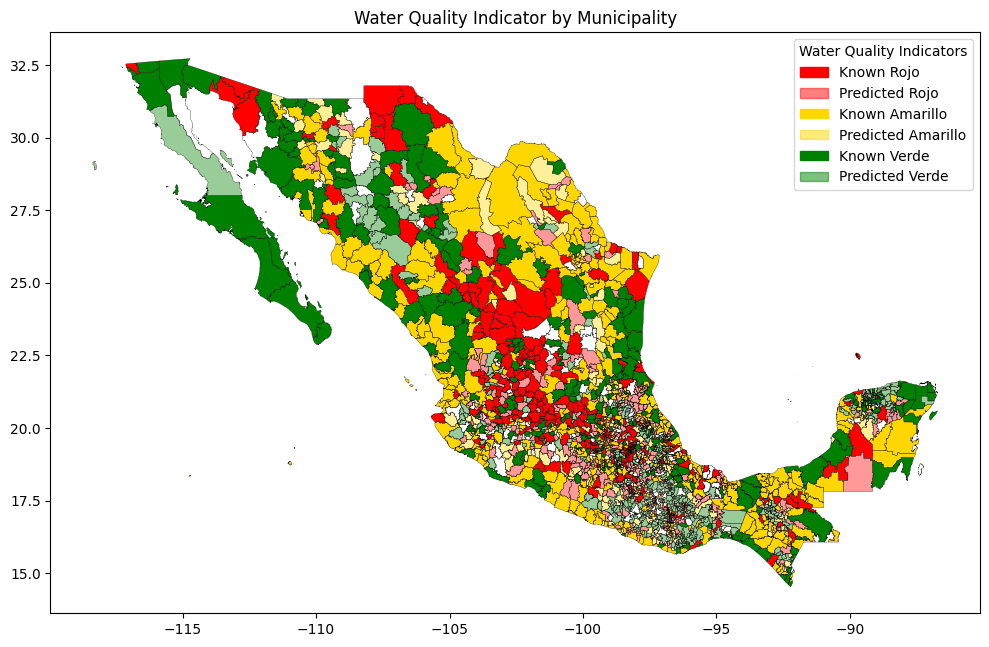

In [68]:
viz_on_map_with_predictions(df_copy, df_predictions, 
                              color_col='semaforo', 
                              pred_col='preds_label',
                              color_map={
                                  'Rojo': 'red',
                                  'Amarillo': 'gold',
                                  'Verde': 'green'},
                              title='Water Quality Indicator by Municipality')

In [69]:
print(len(df_predictions))
df_predictions[df_predictions['preds']==0]

1285


,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,agua_AR,agua_FC,agua_PT,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,semaforo,preds,preds_label
CVEGEO,,,,,,,,,,,,,,,
4012,15297,9.479167,28788.188130,118.62900,22.668040,0,0,0,0.825679,44,0.000000,3.642857,NaN,0.0,Amarillo
5001,1022,433.357143,73795.654790,77.47371,2.789981,0,2,0,0.482459,0,0.000000,1.018018,NaN,0.0,Amarillo
5005,1643,484.421488,210281.651200,84.32739,1.071422,1,2,0,0.507179,0,0.000000,1.000000,NaN,0.0,Amarillo
5008,3047,444.285714,101816.345300,81.31518,1.619239,0,4,0,0.442901,0,0.000000,1.000000,NaN,0.0,Amarillo
5031,24759,681.650602,640945.754600,78.78546,3.478129,1,4,0,0.374044,0,0.000000,53.583333,NaN,0.0,Amarillo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31079,45062,62.503289,274910.146200,110.12220,8.514677,0,50,0,0.786536,0,1.000000,18.330600,NaN,0.0,Amarillo
31105,3293,9.878788,4905.555864,100.12950,2.580974,0,2,0,0.900595,0,0.000000,1.777778,NaN,0.0,Amarillo
32002,4942,1915.571429,20054.650530,63.67896,3.425692,4,6,0,0.946766,0,0.000000,2.000000,NaN,0.0,Amarillo


In [72]:
df_predictions['preds_label'].value_counts()

preds_label
Rojo        519
Verde       439
Amarillo    327
Name: count, dtype: int64

In [70]:
y_train["semaforo_encoded"].value_counts()

semaforo_encoded
0    348
1    258
2    230
Name: count, dtype: int64

In [75]:
len(df_copy[df_copy['preds'].notna()])/2478


0.940677966101695

In [76]:
len(df_copy[df_copy['semaforo'].notna()])/2478


0.42211460855528654

In [86]:
df_predictions['AREA'][df_predictions['preds']==2].sum()/df_copy['AREA'].sum()

0.09950959899255407

In [90]:
(2478-len(df_copy[df_copy['semaforo'].notna()]))/2478

0.5778853914447135

In [91]:
len(df_predictions)/(2478-len(df_copy[df_copy['semaforo'].notna()]))

0.8973463687150838